# Exploratory Data Analysis - Train Validation Set Differences

This notebook looks at the exploratory data analysis of the train and validation set of the arXiv CS dataset. In particular, the differences will be clarified.

## Prerequisites

In this section, all the basic requirements are met in order to keep the analyses as compact as possible.
### Loading the packages and defining the visualisations

In [1]:
import torch
from dataset_split.dataset_splitter import Dataset_Splitter
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
import ogb
import sys
import os
current_dir = os.getcwd()
if os.path.basename(current_dir) != 'link-prediction-in-graphs':
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
print(f"current working directory: {os.getcwd()}")
# ausführen
sys.path.append('modelling/')


# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18


def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    return dot_product / (magnitude_v1 * magnitude_v2)


def calc_similarities(graph, nx_graph, edges, no_random=False):
    # Calculate Similarities between all pairs of nodes
    edges = edges.T
    node_similarities = []
    for i in range(len(edges[:, 0])):
        node_similarities.append(
            cosine_similarity(
                graph.x[edges[i][0]],
                graph.x[edges[i][1]]))

    nodes = list(nx_graph.nodes())
    n_links = len(edges[0])
    random_links = np.array(random.choices(
        nodes, k=n_links * 2)).reshape((2, n_links))
    if no_random:
        # Calculate similarities between all pairs of nodes
        node_similarities_random = []
        for i in range(len(random_links[0])):
            node_similarities_random.append(
                cosine_similarity(
                    graph.x[random_links[0][i]],
                    graph.x[random_links[1][i]]))
        return node_similarities, node_similarities_random
    return node_similarities


def replace_number(number):
    return f"{number:,}".replace(",", "'")

current working directory: d:\Github\link-prediction-in-graphs


In [2]:
# load dataset
ds_split = Dataset_Splitter()
dataset = ds_split.load_dataset("ogbn-arxiv")
data = dataset[0]

split_edge, edge_index = ds_split.get_edges_split(dataset)
train_nodes = np.unique(split_edge["train"]["source_node"])
valid_nodes = np.unique(split_edge["valid"]["source_node"])

train_edges = torch.cat((split_edge['train']['source_node'].unsqueeze(
    0), split_edge['train']['target_node'].unsqueeze(0)), dim=0)
valid_edges = torch.cat((split_edge['valid']['source_node'].unsqueeze(
    0), split_edge['valid']['target_node'].unsqueeze(0)), dim=0)

nx_graph_train = nx.DiGraph()

# add training nodes and their edges to the graph
nx_graph_train.add_nodes_from(train_nodes)
nx_graph_train.add_edges_from([edge for edge in train_edges.T])

nx_graph_valid = nx.DiGraph()
# add training nodes and their edges to the graph
nx_graph_valid.add_nodes_from(valid_nodes)
nx_graph_valid.add_edges_from([edge for edge in valid_edges.T])

train_target_nodes = split_edge['train']['target_node']
valid_target_nodes = split_edge['valid']['target_node']

Creating Splits for dataset ogbn-arxiv
Returning Splits for dataset ogbn-arxiv


## Node Similarities
Node similarities between the validation and training set is calculated.

In [3]:
node_similarities_train, node_similarities_random_train = calc_similarities(
    data, nx_graph_train, train_edges, no_random=True)
node_similarities2_valid, node_similarities_random_valid = calc_similarities(
    data, nx_graph_valid, valid_edges, no_random=True)
df1 = pd.DataFrame({'cosine similarity': node_similarities_train,
                   'Typ': 'Positive Links', 'dataset': 'train'})
df2 = pd.DataFrame({'cosine similarity': node_similarities2_valid,
                   'Typ': 'Positive Links', 'dataset': 'valid'})

train_min = np.round(df1['cosine similarity'].min(), 4)
val_min = np.round(df2['cosine similarity'].min(), 4)
train_max = np.round(df1['cosine similarity'].max(), 4)
val_max = np.round(df2['cosine similarity'].max(), 4)

### Plot Similarity Distribution


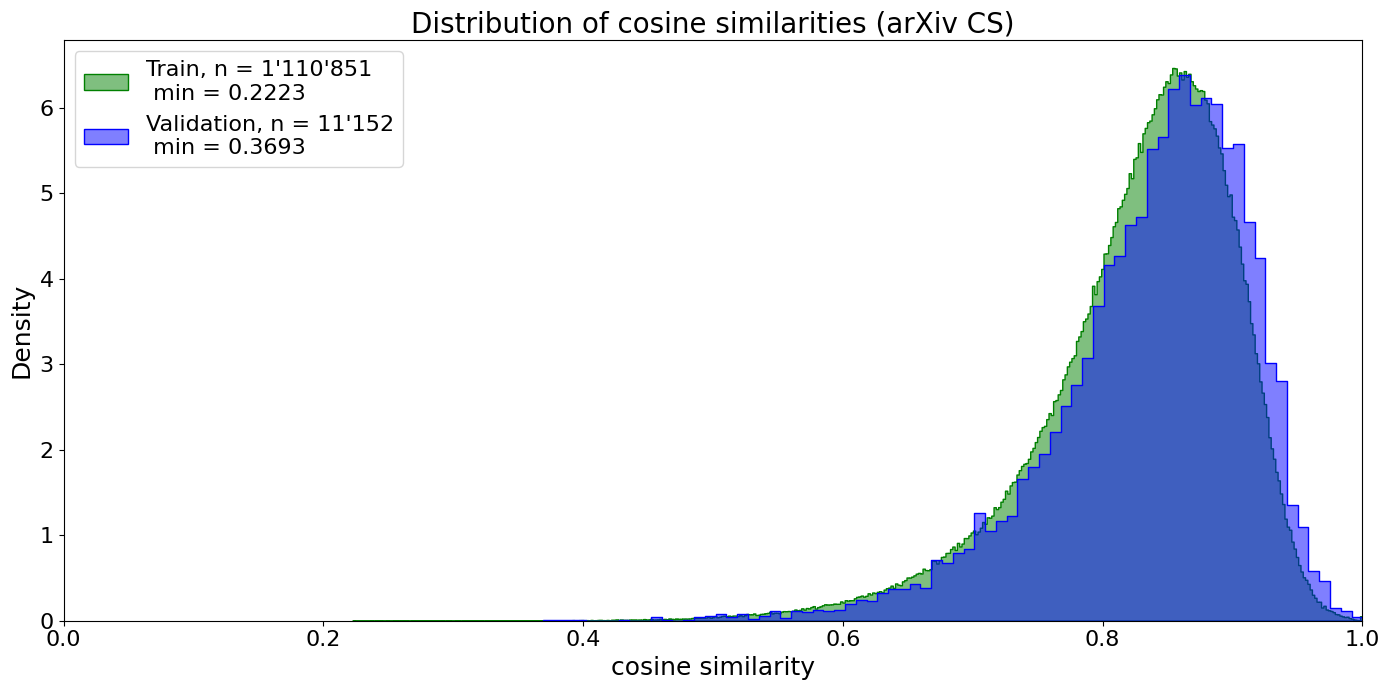

In [5]:
# Concatenate all dataframes into a single one
df_cosine = pd.concat([df1, df2])
plt.figure(figsize=(14, 7))
plt.title("Distribution of cosine similarities (arXiv CS)")
# Plot for the first graph
sns.histplot(data=df_cosine[df_cosine['dataset'] == 'train'], x='cosine similarity',
             kde=False,  element='step', stat='density', color="green", alpha=0.5, label=f"Train, n = {replace_number(len(df_cosine[df_cosine['dataset'] == 'train']))}\n min = {str(train_min)}",)

# Plot for the second graph
sns.histplot(data=df_cosine[df_cosine['dataset'] == 'valid'],
             x='cosine similarity', kde=False, element='step', stat='density', color="blue", alpha=0.5, label=f"Validation, n = {replace_number(len(df_cosine[df_cosine['dataset'] == 'valid']))}\n min = {str(val_min)}",)
plt.xlim(0, 1)
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()